In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Dataset

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Dataset


In [ ]:
# Hyperparameters
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS = 3
EPOCHS = 50
n_classes = 5

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "train1",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5034 files belonging to 5 classes.


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "test1",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1162 files belonging to 5 classes.


In [ ]:
class_names = train_ds.class_names

# Prefetch datasets for performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# Load EfficientNetB0 model
base_model = tf.keras.applications.EfficientNetB0(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), include_top=False, weights="imagenet")
base_model.trainable = False  # Freeze the base model

In [ ]:
# Build the EfficientNet model
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
output_layer = layers.Dense(n_classes, activation="softmax")(x)

model = models.Model(inputs=base_model.input, outputs=output_layer)

In [ ]:
# Compile the model
model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=["accuracy"])


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,055,976 (15.47 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
    verbose=1
)


Epoch 1/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 768s 3s/step - accuracy: 0.5943 - loss: 1.0520 - val_accuracy: 0.9234 - val_loss: 0.3018
Epoch 2/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 51s 39ms/step - accuracy: 0.9126 - loss: 0.3124 - val_accuracy: 0.9630 - val_loss: 0.1802
Epoch 3/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9424 - loss: 0.2161 - val_accuracy: 0.9664 - val_loss: 0.1385
Epoch 4/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9519 - loss: 0.1772 - val_accuracy: 0.9639 - val_loss: 0.1164
Epoch 5/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.9586 - loss: 0.1493 - val_accuracy: 0.9811 - val_loss: 0.0954
Epoch 6/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.9632 - loss: 0.1326 - val_accuracy: 0.9768 - val_loss: 0.0828
Epoch 7/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9689 - loss: 0.1191 - val_accuracy: 0.9897 - val_loss: 0.0697
Epoch 8/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.9663 - loss: 0.1075 - val_

In [ ]:
# Evaluate the model on the test set
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {scores[1] * 100:.2f}%")

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9963 - loss: 0.0111
Test Accuracy: 99.48%


In [ ]:
# Plot training accuracy and loss
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]


Text(0.5, 1.0, 'Training and Validation Accuracy')

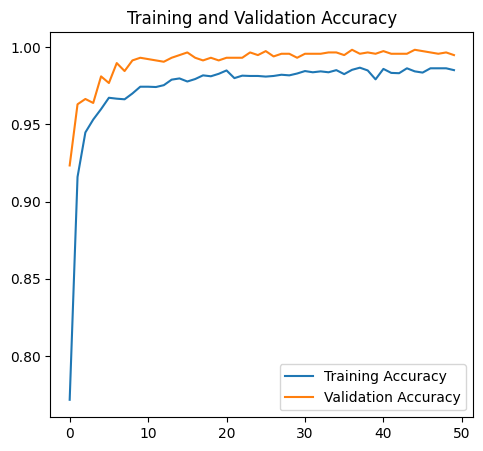

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label="Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")


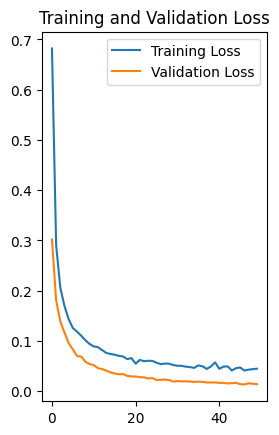

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label="Training Loss")
plt.plot(range(EPOCHS), val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Predicted label: up curl (90.28%)


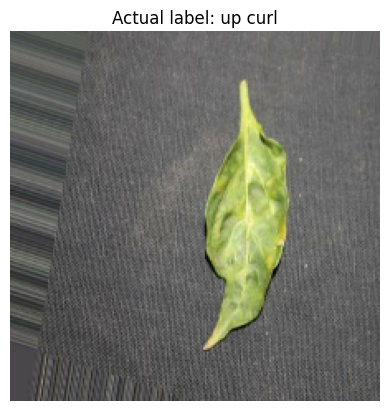

In [ ]:
# Display first image prediction from test set
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype("uint8")
    first_label = labels_batch[0].numpy()
    plt.imshow(first_image)
    plt.title(f"Actual label: {class_names[first_label]}")
    plt.axis("off")
     # Predict the batch
    batch_prediction = model.predict(images_batch)
    predicted_class_idx = np.argmax(batch_prediction[0])
    predicted_class_name = class_names[predicted_class_idx]
    confidence = batch_prediction[0][predicted_class_idx]

    print(f"Predicted label: {predicted_class_name} ({confidence * 100:.2f}%)")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━

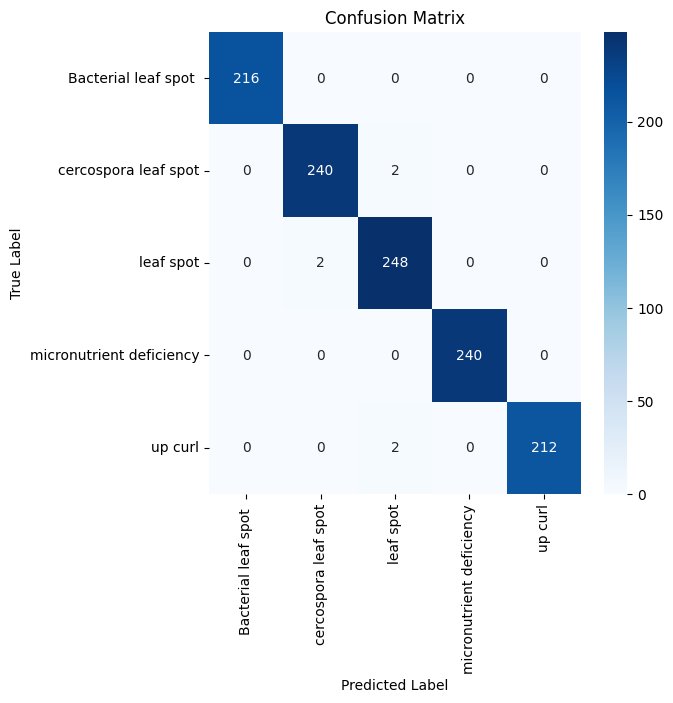

                          precision    recall  f1-score   support

    Bacterial leaf spot        1.00      1.00      1.00       216
    cercospora leaf spot       0.99      0.99      0.99       242
               leaf spot       0.98      0.99      0.99       250
micronutrient deficiency       1.00      1.00      1.00       240
                 up curl       1.00      0.99      1.00       214

                accuracy                           0.99      1162
               macro avg       1.00      0.99      1.00      1162
            weighted avg       0.99      0.99      0.99      1162



In [ ]:
 #Confusion matrix and classification report
y_true = []
y_pred = []
for images_batch, labels_batch in test_ds:
    y_true.extend(labels_batch.numpy())
    predictions = model.predict(images_batch)
    y_pred.extend(np.argmax(predictions, axis=-1))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)


In [ ]:
# Save the model
model.save("chilli_efficientnet.h5")